In [6]:
%load_ext autoreload
%config Completer.use_jedi = False

In [7]:
%autoreload 2
import FEMOL
import numpy as np
import pygmsh
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import scipy.sparse

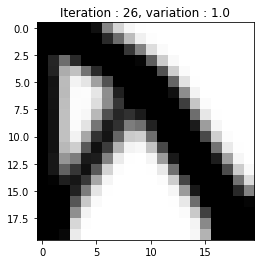

In [341]:
topo = FEMOL.TOPOPT_Problem(Problem=problem, method='SIMP', penal=3, volfrac=0.5)
topo.solve()

In [342]:
np.sqrt(np.sum(mesh.U ** 2))

19.2123681436521

In [125]:
mesh = FEMOL.mesh.rectangle_Q4(1, 1, 20, 20)

problem = FEMOL.FEM_Problem(mesh=mesh, physics='displacement', model='plane')

problem.define_materials(FEMOL.materials.general_isotropic())
problem.define_tensors(1)

problem.add_fixed_domain(FEMOL.domains.inside_box([0], [[0, 1]]))
problem.add_forces([0, -0.1], lambda x, y : (x == 1 and y == 0))

problem.assemble('K')


def fitness(child):
    p = 1
    problem.assemble('K', X=child, p=p)
    mesh = problem.solve(verbose=False)
    fit = np.sqrt(np.sum(mesh.U**2))
    return fit

In [410]:
from scipy.ndimage import gaussian_filter

def generator(shape):
    X = np.random.randint(0, 2, size=shape).astype(float)
    X[X==0] = 0.001
    X = filtre(X)
    return {'quad':X}

def constrain(X):
    shape = X.shape[0]
    if np.sum(X) > shape/2:
        X = X * (shape*0.5 / np.sum(X) )
    return X

def filtre(X):
    X = constrain(X)
    X_filt = gaussian_filter(X.reshape(20, 20), sigma=1.1)
    X_filt[X_filt<0.5] = 0.001
    X_filt[X_filt>=0.5] = 1
    return X_filt.flatten()

def breed1(parent1, parent2):
    shape = parent1['quad'].shape[0]
    i = np.random.randint(np.sqrt(shape).astype(int))
    j = np.random.randint(np.sqrt(shape).astype(int))
    child = parent2['quad'].reshape(20, 20)
    child[:i, :j] = parent1['quad'].reshape(20,20)[:i, :j]
    child = filtre(child.flatten())
    return {'quad':child}

def breed2(parent1, parent2):
    child = parent1['quad'] + parent2['quad']
    child[child==2] = 1
    child = filtre(child.flatten())
    return {'quad':child}

def mutate(parent):
    shape = parent['quad'].shape[0]
    i = np.random.randint(np.sqrt(shape).astype(int))
    j = np.random.randint(np.sqrt(shape).astype(int))
    X = parent['quad'].reshape(20,20)
    X[:i, :j] = np.random.randint(0, 2, size=shape).astype(float).reshape(20,20)[:i, :j]
    X[X==0] = 0.001
    X = filtre(X)
    return {'quad':X}

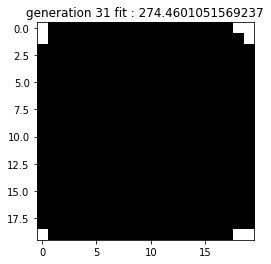

KeyboardInterrupt: 

In [411]:
generation_num = 100
generation_size = 6
size = mesh.all_cells.shape[0]
generation = [generator(size) for i in range(generation_size)]

gen = 0

while gen < generation_num:
    gen +=1
    generation_fit = [fitness(child) for child in generation]
    indexes = np.argsort(generation_fit)[:2]
    parents = np.array(generation)[indexes]
    
    clear_output(wait=True)
    X = parents[0]['quad'].reshape(20, 20)
    plt.imshow(np.rot90(X), cmap='Greys')
    plt.title('generation ' + str(gen) + ' fit : ' + str(min(generation_fit)))
    plt.show()
    display()

    childs = []
    childs[:generation_size//2] = [breed2(parents[0], parents[1]) for i in range(generation_size//2)]
    childs[generation_size//2:] = [mutate(parents[np.random.randint(0, 2)]) for i in range(generation_size//2)]
    childs[-1] = generator(childs[-1]['quad'].shape[0])
    generation = childs
        


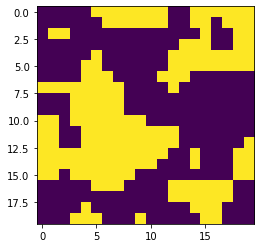

In [402]:
X = generator(400)['quad']
plt.imshow(X.reshape(20,20))

k = np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]])
X2 = scipy.ndimage.convolve(X.reshape(20, 20), k, mode='constant', cval=1.0)

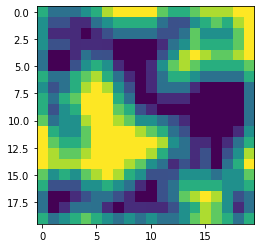

In [403]:
plt.imshow(X2)

In [407]:
X2*(1/X2.max())

array([[0.625375, 0.375625, 0.375625, 0.375625, 0.5005  , 0.625375, 0.875125, 1.      , 1.      , 1.      , 1.      , 0.75025 , 0.625375, 0.625375, 0.75025 , 0.875125, 0.875125, 0.875125, 1.      ,
        1.      ],
       [0.5005  , 0.25075 , 0.25075 , 0.125875, 0.125875, 0.375625, 0.5005  , 0.625375, 0.625375, 0.625375, 0.625375, 0.375625, 0.25075 , 0.25075 , 0.5005  , 0.625375, 0.75025 , 0.625375, 0.875125,
        1.      ],
       [0.5005  , 0.125875, 0.125875, 0.125875, 0.001   , 0.125875, 0.25075 , 0.375625, 0.375625, 0.375625, 0.375625, 0.25075 , 0.25075 , 0.375625, 0.75025 , 0.5005  , 0.5005  , 0.5005  , 0.75025 ,
        1.      ],
       [0.5005  , 0.25075 , 0.25075 , 0.125875, 0.125875, 0.125875, 0.125875, 0.001   , 0.001   , 0.001   , 0.001   , 0.125875, 0.375625, 0.5005  , 0.75025 , 0.625375, 0.625375, 0.625375, 0.75025 ,
        1.      ],
       [0.375625, 0.001   , 0.001   , 0.125875, 0.375625, 0.25075 , 0.25075 , 0.001   , 0.001   , 0.001   , 0.001   , 0.25075 , 0.50